# Equities Momentum Statistical Arbitrage Systematic Trading Model

Strategy:
* Model generates momentum based trade entry signals in single name equities
* validates entry signals using autocorrelation
* further validates long/short trade entry signals with a risk-on/off market regime indicator 

Model specs:
- Control panel where model parameters can be tested.
- Data download + cleaning from Yahoo Finance. Bloomberg and Refinitiv unavailable on personal laptop. 
- Signal generation: momentum z-score, validated by autocorrelation and risk-on/off market regime composite indicator.
- Capital management: Limit positions by capital allocated to the strategy.
- Risk management: Position sizing via trade level stop loss and take profit and portfolio-level VaR risk limit.
- In-sample optimization of the portfolio VaR limit and out-of-sample evaluation.

About me:
- Date: 28 Sept 2025.
- Began learning python on 9 June 2025. 16 weeks learning. This is my 3rd project. (1st pairs trading stat arb, 2nd HJM model calibration)
- Objective: demonstrate quant research and python coding competency.

#### 1) Setup and dependencies

Install libraries, if required.

In [ ]:
!pip install yfinance pandas numpy matplotlib scipy python-dateutil

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# display helper
from IPython.display import display

#### 2) Control panel (edit to change model behaviour)
Configurable parameters collected here.

In [3]:
CONTROL_PANEL = {
    # Data threshold
    "data_thresh":1.0,
    
    # Periods in years
    "years_ago_start": 5,       # start of in sample period (use minimal window to reduce processing time on personal laptop)
    "in_sample_years": 2,       # length of in-sample window (use minimal window to reduce processing time on personal laptop)

    # Momentum signal
    "momentum_lookback_days": 90,
    "momentum_threshold_z": 0.25,

    # Autocorrelation
    "autocorr_lag": 1,
    "autocorr_min": 0.0,

    # Risk-on/off indicator tickers in yahoo finance
    "risk_tickers": {
        "vix": "^VIX",
        "gold": "GLD",
        "credit": "^TNX",
    },

    # index and constituent tickers
    "indx_ticker": "^GSPC",
    "indx_tickers": [                                                                # full constituent list as of 26/09/2025
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'BRK-B', 'JPM', 'JNJ', 'V', 'PG',   # minimise tickers to min processing speed on personal laptop
        'NVDA', 'UNH', 'HD', 'XOM', 'CVX', 'MA', 'TSLA', 'AVGO', 'LLY', 'PFE',
        'ABBV', 'PEP', 'COST', 'MRK', 'KO', 'WMT', 'DIS', 'MCD', 'ABT', 'TMO',
#        'DHR', 'VZ', 'ADBE', 'NFLX', 'CRM', 'ACN', 'CMCSA', 'CSCO', 'TXN', 'NKE',
#        'WFC', 'PM', 'RTX', 'T', 'QCOM', 'UPS', 'IBM', 'CVS', 'SCHW', 'BA',
#        'MDT', 'SPGI', 'ORCL', 'CAT', 'GE', 'INTU', 'AMGN', 'LOW', 'UNP', 'AXP',
#        'DE', 'PLD', 'SBUX', 'GS', 'ISRG', 'NOW', 'HON', 'BKNG', 'AMT', 'SYK',
#        'LMT', 'ADI', 'MMC', 'C', 'TJX', 'VRTX', 'PGR', 'BLK', 'MO', 'CI',
#        'MS', 'ELV', 'ZTS', 'SO', 'DUK', 'MMM', 'BDX', 'EOG', 'REGN', 'CL',
#        'NEE', 'FI', 'ICE', 'APD', 'SLB', 'FIS', 'PSA', 'AON', 'ITW', 'CME',
#        'SHW', 'MCK', 'PNC', 'MPC', 'FDX', 'NSC', 'USB', 'EMR', 'COF', 'ETN',
#        'KLAC', 'SNPS', 'TGT', 'MAR', 'WM', 'GD', 'ADP', 'PXD', 'CCI', 'HUM',
#        'NXPI', 'AEP', 'NOC', 'DG', 'ROP', 'OXY', 'MCO', 'EW', 'PSX', 'MET',
#        'ORLY', 'AIG', 'KMB', 'SRE', 'APH', 'ECL', 'GIS', 'KMI', 'ADSK', 'IDXX',
#        'CTAS', 'VLO', 'MSCI', 'WELL', 'PCAR', 'F', 'DXCM', 'AMP', 'AFL', 'SPG',
#        'DLR', 'MCHP', 'WMB', 'TDG', 'MNST', 'FTNT', 'NUE', 'KHC', 'HSY', 'PAYX',
#        'ROST', 'YUM', 'CTVA', 'ALL', 'HLT', 'STZ', 'PRU', 'DD', 'OKE', 'CPRT',
#        'ODFL', 'CMG', 'AZO', 'FAST', 'TRV', 'VICI', 'EXC', 'DOW', 'RMD', 'MTD',
#        'AWK', 'WBA', 'DLTR', 'GLW', 'ED', 'KVUE', 'ANSS', 'HPQ', 'EFX', 'ALB',
#        'OTIS', 'FTV', 'HCA', 'GWW', 'ROK', 'TT', 'EBAY', 'VRSK', 'WEC', 'CDW',
#        'ES', 'BIIB', 'DHI', 'RCL', 'WY', 'LYB', 'CHTR', 'FANG', 'CNC', 'CB',
#        'CPAY', 'AME', 'MKC', 'BKR', 'IR', 'SBAC', 'VMC', 'DFS', 'IFF', 'WST',
#        'HAL', 'DAL', 'EIX', 'ZBH', 'DTE', 'WTW', 'ULTA', 'NEM', 'PEG', 'RSG',
#        'FITB', 'LHX', 'STT', 'CARR', 'TSCO', 'CTSH', 'EQR', 'MLM', 'HES', 'ARE',
#        'FRC', 'VRSN', 'WBD', 'EXR', 'ETR', 'FE', 'HBAN', 'RF', 'PFG', 'VTR',
#        'DOV', 'MAA', 'EXPE', 'NTAP', 'MTB', 'ABC', 'AKAM', 'CFG', 'ETSY', 'LUV',
#        'BBY', 'POOL', 'CMS', 'BALL', 'TDY', 'CAG', 'HIG', 'MOH', 'SWKS', 'TER',
#        'CEG', 'INCY', 'SYY', 'XYL', 'LEN', 'TYL', 'PKI', 'JKHY', 'BR', 'UAL',
#        'BRO', 'IP', 'CF', 'SEDG', 'CLX', 'FDS', 'LVS', 'J', 'TROW', 'FLT',
#        'STE', 'NTRS', 'AMCR', 'LKQ', 'DGX', 'CTRA', 'HPE', 'KEY', 'DPZ', 'CBOE',
#        'NDAQ', 'MRO', 'BXP', 'TPR', 'LDOS', 'HOLX', 'IEX', 'APA', 'AVB', 'GRMN',
#        'CRL', 'WAT', 'IPG', 'CHD', 'PEAK', 'RE', 'RJF', 'BBWI', 'KMX', 'A',
#        'BIO', 'GEN', 'LW', 'UDR', 'TFX', 'EMN', 'CPT', 'IRM', 'CE', 'MGM',
#        'PNW', 'ATO', 'HWM', 'ZBRA', 'ESS', 'VTRS', 'PKG', 'FMC', 'NI', 'JBHT',
#        'SJM', 'PARA', 'TRMB', 'BG', 'L', 'JCI', 'FFIV', 'PNR', 'TECH', 'WRB',
#        'HST', 'NRG', 'AAP', 'LW', 'BF-B', 'REG', 'RL', 'CPB', 'MOS', 'DRI',
#        'GL', 'UHS', 'CMA', 'AIZ', 'PNFP', 'BWA', 'ALK', 'RHI', 'NWSA', 'NWS',
#        'FOX', 'FOXA', 'DISH', 'VFC', 'HAS', 'NWL', 'IPGP', 'COL', 'ROL', 'SEE',
#        'TAP', 'FRT', 'K', 'OGN', 'WHR', 'LEG', 'BEN', 'IVZ', 'NLOK', 'RLGY',
#        'DVA', 'AOS', 'PBCT', 'HRB', 'TXT', 'ALK', 'JNPR', 'LNC', 'COO', 'BLL',
#        'GPS', 'MHK', 'FLIR', 'VNO', 'MAC', 'KSS', 'M', 'JWN', 'DDS', 'ANF',
#        'UA', 'UAA', 'LUMN', 'LNT', 'NI', 'ETFC', 'SYF', 'ALLY', 'SNA', 'WHR',
#        'HBI', 'GPC', 'OMC', 'DISCA', 'DISCK', 'VIAC', 'VIAV', 'LBTYA', 'LBTYK',
#        'QRVO', 'SWK', 'MAS', 'PHM', 'TOL', 'LEN', 'DHI', 'NVR', 'KBH', 'MTH'
    ],
    
    # Capital & sizing
    "initial_capital": 10_000_000,
    "portfolio_var_limit_pct": 0.03,  # optimise using in-sample backtesting, then apply optimised parameter in out of sample data
    "var_confidence": 0.95,
    "max_positions": 50,

    # Trade management
    "stop_loss_pct": 0.005,     # e.g. 0.08 = 8%
    "take_profit_pct": 0.1,

    # Backtest controls
    "use_all_stocks_if_few_available": True,
}

#### 3) Date calcs
Calculates in sample and outsample period start and end dates 

In [5]:
def years_ago_date(years_back:int):
    today = dt.date.today()
    return today - relativedelta(years=years_back)


def get_date_ranges(panel):
    end_date = dt.date.today()
    in_start = years_ago_date(panel['years_ago_start'])
    in_end = in_start + relativedelta(years=panel['in_sample_years']) - dt.timedelta(days=1)
    out_start = in_end + dt.timedelta(days=1)
    out_end = end_date
    return {
        'in_start': in_start.strftime('%Y-%m-%d'),
        'in_end': in_end.strftime('%Y-%m-%d'),
        'out_start': out_start.strftime('%Y-%m-%d'),
        'out_end': out_end.strftime('%Y-%m-%d'),
    }

#### 4) Data download and cleaning

Download close prices for all single name equities and their index. Adjusted close prices not available in yahoo finance and beyond scope of this demo to implement.  
Drop tickers with mostly-missing data.  
Produce two DataFrames: raw prices and daily log returns.

In [7]:
def compute_log_returns(price_df):
    return np.log(price_df).diff().ffill(limit=1).dropna()

# run download
ranges = get_date_ranges(CONTROL_PANEL) # results in a dictionary of dates
all_start = years_ago_date(CONTROL_PANEL['years_ago_start']).strftime('%Y-%m-%d') # converts to a date
all_end = dt.date.today().strftime('%Y-%m-%d')
print('Downloading tickers and price history... (may take several minutes)')

prices_all = yf.download(CONTROL_PANEL['indx_tickers'], start=all_start, end=all_end)['Close']

# index benchmark
indx = yf.download(CONTROL_PANEL['indx_ticker'], start=all_start, end=all_end)['Close']

# drop tickers with too much missing data
prices_all = prices_all.dropna(axis=1, thresh=int(CONTROL_PANEL['data_thresh']*prices_all.shape[0]))
raw_prices = prices_all.copy()
log_returns = compute_log_returns(raw_prices)

print('raw_prices:')
display(raw_prices)
print('log_returns:')
display(log_returns)
print('indx:')
display(indx)

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


raw_prices:


Ticker,AAPL,ABBV,ABT,AMZN,AVGO,BRK-B,COST,CVX,DIS,GOOGL,...,NVDA,PEP,PFE,PG,TMO,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-29,110.977348,71.047890,96.212532,157.244003,32.554413,210.440002,324.517273,57.931938,123.343773,72.798904,...,13.185502,117.868996,27.084381,121.292854,428.795929,139.690002,281.219604,192.428558,42.641342,27.596636
2020-09-30,112.650459,71.620270,99.541862,157.436493,32.559769,212.940002,327.152863,58.012512,122.045410,72.778046,...,13.489325,119.106506,27.481243,122.821617,435.884277,143.003326,288.265106,192.939926,43.502621,27.636890
2020-10-01,113.603722,71.252327,99.368080,161.063004,32.942280,212.020004,330.341492,56.739464,121.288033,73.885414,...,13.573068,120.997093,27.234138,123.042534,432.606720,149.386673,289.467163,196.201096,44.488289,26.670849
2020-10-02,109.936546,70.418289,97.410713,156.250000,31.890385,211.179993,327.162170,57.359875,120.540497,72.281464,...,13.022498,118.642433,27.241629,122.052826,429.506683,138.363327,288.459290,194.377518,43.686077,26.550091
2020-10-05,113.321617,71.898285,99.294884,159.960007,32.718857,212.360001,330.452087,58.576523,121.347054,73.633659,...,13.600983,118.530708,27.518692,123.175087,444.917542,141.893326,294.164093,196.384460,44.090282,27.161921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,256.079987,222.589996,136.619995,227.630005,338.790009,493.709991,943.260010,156.050003,112.559998,252.529999,...,183.610001,141.029999,24.040001,153.070007,474.989990,434.209991,341.299988,344.359985,102.820000,112.019997
2025-09-23,254.429993,222.610001,135.889999,220.710007,338.940002,494.100006,943.599976,157.419998,112.250000,251.660004,...,178.429993,141.899994,24.129999,152.500000,469.750000,425.850006,347.690002,338.700012,102.519997,113.949997
2025-09-24,252.309998,219.990005,133.889999,220.210007,339.309998,497.089996,945.270020,159.179993,113.430000,247.139999,...,176.970001,142.169998,24.090000,152.419998,468.000000,442.790009,351.809998,338.679993,102.730003,114.559998


log_returns:


Ticker,AAPL,ABBV,ABT,AMZN,AVGO,BRK-B,COST,CVX,DIS,GOOGL,...,NVDA,PEP,PFE,PG,TMO,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,0.014964,0.008024,0.034019,0.001223,0.000165,0.011810,0.008089,0.001390,-0.010582,-0.000287,...,0.022781,0.010444,0.014546,0.012525,0.016396,0.023442,0.024745,0.002654,0.019997,0.001458
2020-10-01,0.008427,-0.005151,-0.001747,0.022773,0.011679,-0.004330,0.009699,-0.022189,-0.006225,0.015101,...,0.006189,0.015748,-0.009032,0.001797,-0.007548,0.043670,0.004161,0.016761,0.022405,-0.035580
2020-10-02,-0.032813,-0.011774,-0.019895,-0.030338,-0.032452,-0.003970,-0.009671,0.010875,-0.006182,-0.021948,...,-0.041409,-0.019652,0.000275,-0.008076,-0.007192,-0.076655,-0.003488,-0.009338,-0.018197,-0.004538
2020-10-05,0.030327,0.020799,0.019158,0.023467,0.025647,0.005572,0.010006,0.020989,0.006669,0.018535,...,0.043464,-0.000942,0.010119,0.009153,0.035252,0.025193,0.019584,0.010272,0.009210,0.022783
2020-10-06,-0.029088,-0.023474,-0.021508,-0.031512,-0.005807,-0.009938,-0.000642,-0.005517,-0.019976,-0.021686,...,0.006866,-0.016300,-0.015908,0.001577,-0.010663,-0.027870,-0.011698,-0.015298,-0.008285,-0.010428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,0.042193,0.000539,0.004254,-0.016772,-0.016278,0.001743,-0.008340,-0.001025,-0.010605,-0.008635,...,0.038530,-0.005163,0.000416,-0.019217,-0.009617,0.018925,0.013599,0.008018,0.004777,-0.007116
2025-09-23,-0.006464,0.000090,-0.005358,-0.030872,0.000443,0.000790,0.000360,0.008741,-0.002758,-0.003451,...,-0.028618,0.006150,0.003737,-0.003731,-0.011093,-0.019441,0.018549,-0.016573,-0.002922,0.017082
2025-09-24,-0.008367,-0.011839,-0.014827,-0.002268,0.001091,0.006033,0.001768,0.011118,0.010457,-0.018124,...,-0.008216,0.001901,-0.001659,-0.000525,-0.003732,0.039008,0.011780,-0.000059,0.002046,0.005339


indx:


Ticker,^GSPC
Date,
2020-09-29,3335.469971
2020-09-30,3363.000000
2020-10-01,3380.800049
2020-10-02,3348.419922
2020-10-05,3408.600098
...,...
2025-09-22,6693.750000
2025-09-23,6656.919922
2025-09-24,6637.970215


#### 5) Signal generation

Momentum is calculated as the rolling cumulative log-return over the lookback window and then standardized (z-score) across time for each equity.  
Entry signals are when z > threshold (long) or z < -threshold (short).

Also calculate autocorrelation on daily log returns to validate that the momentum signal is consistent with recent persistence.

In [9]:
def standardise(series):
    return (series - series.mean()) / series.std(ddof=0)

def compute_momentum_signal(prices, index_prices, lookback_days):
    logrets = compute_log_returns(prices)
    cumlog = logrets.rolling(window=lookback_days, min_periods=lookback_days).sum()
    momentum_z = cumlog.apply(lambda s: standardise(s), axis=0)
    idx_logrets = compute_log_returns(index_prices)
    idx_cumlog = idx_logrets.rolling(window=lookback_days, min_periods=lookback_days).sum()
    idx_z = idx_cumlog.apply(lambda s: standardise(s), axis=0) if isinstance(idx_cumlog, pd.DataFrame) else standardise(idx_cumlog)
    return momentum_z, idx_z

momentum_z, idx_z = compute_momentum_signal(raw_prices, indx, CONTROL_PANEL['momentum_lookback_days'])
print('momentum_z:')
display(momentum_z)
print('idx_z:')
display(idx_z)

momentum_z:


Ticker,AAPL,ABBV,ABT,AMZN,AVGO,BRK-B,COST,CVX,DIS,GOOGL,...,NVDA,PEP,PFE,PG,TMO,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,1.087300,0.982740,0.428517,0.273121,1.270624,-1.047011,-1.245664,0.373325,0.174086,2.385397,...,0.471491,1.203327,0.636309,-0.734182,0.862077,0.674863,0.597082,-0.843019,0.119791,-0.348098
2025-09-23,1.059040,1.501633,0.412301,0.130779,1.280577,-0.857131,-1.173424,0.467769,0.084872,2.148848,...,0.256698,1.476189,0.962623,-0.722923,1.210388,0.491092,0.758944,-1.036971,-0.006458,-0.174868
2025-09-24,1.026343,1.183899,-0.124363,0.254361,1.273996,-0.876053,-1.330467,0.516370,0.175082,2.091451,...,0.242956,1.189504,0.745733,-1.140921,1.202667,0.655402,1.460190,-1.218034,0.062841,-0.206428


idx_z:


Ticker,^GSPC
Date,
2020-09-30,NaN
2020-10-01,NaN
2020-10-02,NaN
2020-10-05,NaN
2020-10-06,NaN
...,...
2025-09-22,1.060749
2025-09-23,0.979852
2025-09-24,0.893598


#### 6) Autocorrelation validation helper

Autocorrelation at lag 1 (or a configurable lag) is used to validate a momentum signal.  
If autocorr >= required_min we accept the sign.

In [11]:
def autocorr_validation(logret_series, lag, required_min):
    try:
        ac = logret_series.autocorr(lag=lag)
        if np.isnan(ac):
            return False
        return ac >= required_min
    except Exception:
        return False

# demo on a single ticker
sample_ticker = raw_prices.columns[0]
print('Sample ticker for autocorr demo:', sample_ticker)
print(f'Autocorr (lag={CONTROL_PANEL['autocorr_lag']}):', autocorr_validation(
    np.log(raw_prices[sample_ticker]).diff().dropna(), CONTROL_PANEL['autocorr_lag'], CONTROL_PANEL['autocorr_min']))

Sample ticker for autocorr demo: AAPL
Autocorr (lag=1): False


#### 7) Risk-on / risk-off composite indicator (optional)

For risk-regime indicators VIX, GLD, and the 10y US Govt Bond, build a simple majority-vote risk signal: +1 => risk-on, -1 => risk-off.  
Each indicator votes risk-off when it has a recent uptick.

In [13]:
def build_risk_on_off(risk_dfs):
    if not risk_dfs:
        return None
    votes = []
    for name, series in risk_dfs.items():
        sr = compute_log_returns(series.to_frame(name))
        if sr.shape[0] < 5:
            continue
        recent = sr.rolling(window=5).sum()
        votes.append((recent[name] > 0).astype(int))
    if not votes:
        return None
    votes_df = pd.concat(votes, axis=1).fillna(0).astype(int)
    vote_sum = votes_df.sum(axis=1)
    threshold = votes_df.shape[1] / 2.0
    risk_signal = pd.Series(index=vote_sum.index, data=np.where(vote_sum > threshold, -1, 1))
    return risk_signal

# download risk tickers
risk_dfs = {}
for name, tk in CONTROL_PANEL['risk_tickers'].items():
    s = yf.download(tk, start=all_start, end=all_end)['Close']
    s.columns = [name]
    risk_dfs[name] = s[name]

risk_signal = build_risk_on_off(risk_dfs)
print('Risk indicators included:', list(risk_dfs.keys()))
if risk_signal is not None:
    print("risk_signal:")
    display(risk_signal.dropna())
else:
    print('No risk-on/off indicators available. Proceeding without regime gating.')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Risk indicators included: ['vix', 'gold', 'credit']
risk_signal:


Date
2020-09-30    1
2020-10-01    1
2020-10-02    1
2020-10-05    1
2020-10-06   -1
             ..
2025-09-22   -1
2025-09-23   -1
2025-09-24   -1
2025-09-25   -1
2025-09-26   -1
Length: 1254, dtype: int32

#### 8) Simple historic-VaR sizing routine

Compute per-ticker 1-day VaR (historic simulation) and allocate equal risk (on the VaR metric) across selected candidates so that sum of per-position VaRs <= portfolio VaR budget.

In [15]:
def compute_historical_var(returns_series, alpha=0.95):
    if returns_series.dropna().empty:
        return 0.0
    var = np.percentile(returns_series.dropna(), (1-alpha)*100)
    return abs(var)

# old
'''
def size_positions_universe(candidate_tickers, hist_returns, panel, available_capital):
    alpha = panel['var_confidence']
    per_unit_vars = {}
    for t in candidate_tickers:
        if t not in hist_returns:
            continue
        series = hist_returns[t]
        if series.dropna().shape[0] < 30:
            per_unit_vars[t] = 0.05
        else:
            per_unit_vars[t] = max(compute_historical_var(series, alpha), 1e-6)
    if not per_unit_vars:
        return {}
    sorted_tickers = sorted(per_unit_vars.keys(), key=lambda x: per_unit_vars[x])  # sort tickers from smallest VaR to largest
    selected = sorted_tickers[:panel['max_positions']]
    total_per_unit_var = sum(per_unit_vars[t] for t in selected)
    var_budget = panel['portfolio_var_limit_pct'] * available_capital
    if total_per_unit_var <= 0:
        return {t: 0 for t in selected}
    x = var_budget / total_per_unit_var
    positions = {t: x for t in selected}
    return positions                       # dictionary: key is ticker, value is position size in cash terms
'''


def size_positions_universe(candidate_tickers, hist_returns, panel, available_capital):
    alpha = panel['var_confidence']
    per_unit_vars = {}
    for t in candidate_tickers:
        if t not in hist_returns:
            continue
        series = hist_returns[t]
        if series.dropna().shape[0] < 30:
            per_unit_vars[t] = 0.05
        else:
            per_unit_vars[t] = max(compute_historical_var(series, alpha), 1e-6)
    if not per_unit_vars:
        return {}

    # select tickers
    sorted_tickers = sorted(per_unit_vars.keys(), key=lambda x: per_unit_vars[x])
    selected = sorted_tickers[:panel['max_positions']]

    # total "inverse risk" weight
    inv_var = np.array([1/per_unit_vars[t] for t in selected])
    inv_var_sum = inv_var.sum()
    var_budget = panel['portfolio_var_limit_pct'] * available_capital

    # position sizing proportional to inverse VaR
    positions = {t: var_budget * (1/per_unit_vars[t])/inv_var_sum for t in selected}

    return positions

#### 9) Backtest engine (daily)

The engine is intentionally straightforward:
- Use the momentum z-score signal and autocorr validation to open positions at daily close.
- Size positions with the VaR method above.
- Exit on stop-loss, take-profit, or when the momentum signal no longer holds.
- If portfolio 1-day VaR (expanding historic estimate of equity returns) exceeds the limit, rescale open positions proportionally.

In [17]:
def run_backtest(prices, index_prices, momentum_z, risk_signal, panel):
    dates = prices.index
    tickers = prices.columns.tolist()
    initial_cap = panel['initial_capital']
    cash = initial_cap
    equity = initial_cap
    positions = {}
    trades = []
    daily_equity = []

    zthr = panel['momentum_threshold_z']
    stop = panel['stop_loss_pct']
    take = panel['take_profit_pct']

    for i, date in enumerate(dates):
        today_prices = prices.loc[date]
        # signals
        signals = {}
        for t in tickers:
            if t not in momentum_z.columns or date not in momentum_z.index:
                continue
            mz = momentum_z.at[date, t]
            if np.isnan(mz):
                continue
            if mz > zthr:
                signals[t] = +1
            elif mz < -zthr:
                signals[t] = -1
        # autocorr validation
        validated = {}
        for t, sgn in signals.items():
            series = np.log(prices[t]).diff().loc[:date].dropna()
            if series.shape[0] < 30:
                continue
            ok = autocorr_validation(series, panel['autocorr_lag'], panel['autocorr_min'])
            if ok:
                validated[t] = sgn
        # regime gating
        if risk_signal is not None and date in risk_signal.index:
            regime = risk_signal.loc[date]
            gated = {}
            for t,sgn in validated.items():
                if regime == 1 and sgn == 1:
                    gated[t] = sgn
                elif regime == -1 and sgn == -1:
                    gated[t] = sgn
            validated = gated
        # sizing
        hist_returns = {t: np.log(prices[t]).diff().loc[:date].dropna() for t in tickers}  # gives a list of log returns for the ticker (t) to the date
        candidates = [t for t in validated.keys() if t not in positions]
        sizes = size_positions_universe(candidates, hist_returns, panel, equity)
        # open
        for t, sgn in validated.items():
            if t in positions:
                continue
            if t not in sizes:
                continue
            pos_value = sizes[t]
            price = today_prices[t]
            if np.isnan(price) or price <= 0:
                continue
            shares = pos_value / price
            positions[t] = {'entry_price': price, 'shares': shares, 'size_cash': pos_value, 'direction': int(sgn), 'entry_date': date}
            cash -= pos_value
            trades.append({'date': date, 'ticker': t, 'action': 'ENTER', 'price': price, 'size_cash': pos_value, 'direction': sgn})
        # update and check exits
        to_remove = []
        for t, pos in positions.items():
            if t not in today_prices or np.isnan(today_prices[t]) or pos['shares'] == 0:
                continue
            current_price = today_prices[t]
            ret = (current_price / pos['entry_price']) - 1.0
            # stop/take
            if pos['direction'] == 1:       # SL or TP for long positions
                if ret <= -stop:
                    cash += pos['shares'] * current_price
                    trades.append({'date': date, 'ticker': t, 'action': 'EXIT_LONG_STOP', 'price': current_price, 
                                   'size_cash': pos['shares']*current_price, 'direction': pos['direction']})
                    to_remove.append(t)
                    continue
                if ret >= take:
                    cash += pos['shares'] * current_price
                    trades.append({'date': date, 'ticker': t, 'action': 'EXIT_LONG_TAKE', 'price': current_price, 
                                   'size_cash': pos['shares']*current_price, 'direction': pos['direction']})
                    to_remove.append(t)
                    continue
            else:                            # SL or TP for short positions
                if ret >= stop:
                    cash += pos['shares'] * current_price
                    trades.append({'date': date, 'ticker': t, 'action': 'EXIT_SHORT_STOP', 'price': current_price,
                                   'size_cash': pos['shares']*current_price, 'direction': pos['direction']})
                    to_remove.append(t)
                    continue
                if ret <= -take:
                    cash += pos['shares'] * current_price
                    trades.append({'date': date, 'ticker': t, 'action': 'EXIT_SHORT_TAKE', 'price': current_price,
                                   'size_cash': pos['shares']*current_price, 'direction': pos['direction']})
                    to_remove.append(t)
                    continue
            # overriding exit (signal disappeared)
            if date in momentum_z.index and t in momentum_z.columns:
                mz = momentum_z.at[date, t]
                if pos['direction'] == 1 and mz < zthr:
                    cash += pos['shares'] * current_price
                    trades.append({'date': date, 'ticker': t, 'action': 'EXIT_LONG_SIGNAL_REVERSAL', 
                                   'price': current_price, 'size_cash': pos['shares']*current_price, 'direction': pos['direction']})
                    to_remove.append(t)
                    continue
                if pos['direction'] == -1 and mz > -zthr:
                    cash += pos['shares'] * current_price
                    trades.append({'date': date, 'ticker': t, 'action': 'EXIT_SHORT_SIGNAL_REVERSAL', 
                                   'price': current_price, 'size_cash': pos['shares']*current_price, 'direction': pos['direction']})
                    to_remove.append(t)
                    continue
        for t in to_remove:
            if t in positions:
                del positions[t]
        # compute equity
        mtm = 0.0
        for t, pos in positions.items():
            if t in today_prices and not np.isnan(today_prices[t]):
                mtm += pos['direction'] * (today_prices[t] - pos['entry_price']) * pos['shares'] + pos['size_cash']
            else:
                mtm += pos['size_cash']
        equity = cash + mtm
        # VaR check (simple expanding historic of eq returns)
        if len(daily_equity) > 1:
            hist_rets = np.array([ (daily_equity[i]/daily_equity[i-1])-1.0 for i in range(1,len(daily_equity)) ])
            if len(hist_rets) > 30:
                var = compute_historical_var(pd.Series(hist_rets), panel['var_confidence'])
                if var > panel['portfolio_var_limit_pct']:
                    scale = panel['portfolio_var_limit_pct'] / (var + 1e-9)
                    for t in list(positions.keys()):
                        pos = positions[t]
                        new_size = pos['size_cash'] * scale
                        pos['shares'] = new_size / today_prices[t]
                        pos['size_cash'] = new_size
                    trades.append({'date': date, 'ticker': 'ALL', 'action': 'RESCALE', 'scale': scale})
                    mtm = sum([ positions[t]['direction'] * (today_prices[t] - positions[t]['entry_price']) * 
                               positions[t]['shares'] + positions[t]['size_cash'] for t in positions ]) if positions else 0.0
                    equity = cash + mtm
        daily_equity.append(equity)
    equity_index = pd.Series(index=dates, data=daily_equity)
    trades_df = pd.DataFrame(trades)
    return trades_df, equity_index

#### 10) Performance metrics and reporting

Compute annualised return, volatility, Sharpe ratio, max drawdown, win ratio and information ratio versus the benchmark.

In [19]:
def compute_performance_metrics(equity_series, benchmark_prices=None):
    eq = equity_series.dropna()
    daily_rets = eq.pct_change().dropna()
    ann_ret = (1 + daily_rets.mean()) ** 252 - 1
    ann_vol = daily_rets.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum = (1 + daily_rets).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    wins = (daily_rets > 0).sum()
    win_ratio = wins / len(daily_rets) if len(daily_rets)>0 else np.nan
    metrics = {
        'annual_return': ann_ret,
        'annual_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'win_ratio': win_ratio,
        'total_return': (eq.iloc[-1] / eq.iloc[0]) - 1
    }
    if benchmark_prices is not None:
        bench = benchmark_prices.loc[eq.index]
        bench_rets = bench.pct_change().dropna()
        common = daily_rets.index.intersection(bench_rets.index)
        active = daily_rets.loc[common] - bench_rets.loc[common]
        ir = active.mean() / active.std() * np.sqrt(252) # if active.std() > 0 else np.nan
        metrics['information_ratio'] = ir
    return metrics, daily_rets

#### 11) In-sample optimisation of portfolio VaR limit

Test a small set of candidate VaR limits and pick the one with highest in-sample Sharpe.  
Intentionally simple. Designed to produce a demonstrable optimisation process for my CV — not a production-grade optimisation routine.

In [23]:
print('Running in-sample optimisation...')

in_start, in_end = ranges['in_start'], ranges['in_end']
out_start, out_end = ranges['out_start'], ranges['out_end']

in_start = pd.to_datetime(in_start) + pd.Timedelta(days=CONTROL_PANEL['autocorr_lag']) # adjust datasets for autocorr_lag in autocorr dataframe

in_prices = raw_prices.loc[in_start:in_end]
out_prices = raw_prices.loc[out_start:out_end]

print("in_prices:")
display(in_prices)

results = []
for candidate in [0.01, 0.2, 0.4, 0.6, 0.8]:
    panel_copy = dict(CONTROL_PANEL)
    panel_copy['portfolio_var_limit_pct'] = candidate
    trades_is, equity_is = run_backtest(in_prices, indx.loc[in_prices.index], momentum_z.loc[in_prices.index], 
                                        risk_signal.loc[in_prices.index] if risk_signal is not None else None, panel_copy)
    metrics_is, _ = compute_performance_metrics(equity_is)
    results.append({'var_limit': candidate, 'annual_return': metrics_is['annual_return'], 'sharpe': metrics_is['sharpe_ratio']})

res_df = pd.DataFrame(results)
print('In-sample optimisation results:')
display(res_df)

best = res_df.loc[res_df['sharpe'].idxmax()]
optimal_var = float(best['var_limit'])
print(f'Optimal portfolio 1-day VaR limit: {optimal_var:.4f}')
CONTROL_PANEL['portfolio_var_limit_pct'] = optimal_var

Running in-sample optimisation...
in_prices:


Ticker,AAPL,ABBV,ABT,AMZN,AVGO,BRK-B,COST,CVX,DIS,GOOGL,...,NVDA,PEP,PFE,PG,TMO,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,112.650459,71.620270,99.541862,157.436493,32.559769,212.940002,327.152863,58.012512,122.045410,72.778046,...,13.489325,119.106506,27.481243,122.821617,435.884277,143.003326,288.265106,192.939926,43.502621,27.636890
2020-10-01,113.603722,71.252327,99.368080,161.063004,32.942280,212.020004,330.341492,56.739464,121.288033,73.885414,...,13.573068,120.997093,27.234138,123.042534,432.606720,149.386673,289.467163,196.201096,44.488289,26.670849
2020-10-02,109.936546,70.418289,97.410713,156.250000,31.890385,211.179993,327.162170,57.359875,120.540497,72.281464,...,13.022498,118.642433,27.241629,122.052826,429.506683,138.363327,288.459290,194.377518,43.686077,26.550091
2020-10-05,113.321617,71.898285,99.294884,159.960007,32.718857,212.360001,330.452087,58.576523,121.347054,73.633659,...,13.600983,118.530708,27.518692,123.175087,444.917542,141.893326,294.164093,196.384460,44.090282,27.161921
2020-10-06,110.072762,70.230225,97.182060,154.998001,32.529396,210.259995,330.240082,58.254246,118.947067,72.054047,...,13.694695,116.614357,27.084381,123.369469,440.198547,137.993332,290.743134,193.403030,43.726498,26.880156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,150.366425,127.753067,95.316681,117.309998,45.373680,268.510010,467.390808,137.014099,100.484856,99.454056,...,12.545927,153.244812,37.804157,126.261780,515.786438,288.589996,491.640869,181.591782,42.792358,81.749123
2022-09-23,148.092285,127.797745,94.948875,113.779999,44.525318,267.769989,447.464050,128.062057,97.868462,98.063652,...,12.500982,153.172089,37.388546,125.677795,516.282288,275.329987,487.982849,179.803162,41.724068,77.398544
2022-09-26,148.426971,126.145119,94.156685,115.150002,43.915409,264.320007,460.799713,124.691780,96.511086,97.497543,...,12.213326,153.108444,37.176495,125.798279,509.858246,276.010010,482.994843,176.509308,42.125080,75.800941


In-sample optimisation results:


,var_limit,annual_return,sharpe
0,0.01,0.007182,1.451179
1,0.20,0.153867,1.576775
2,0.40,0.331198,1.719871
3,0.60,0.535210,1.875000
4,0.80,0.769464,2.042905


Optimal portfolio 1-day VaR limit: 0.8000


#### 12) Run out-of-sample backtest and report

Finally, run the backtest on the out-of-sample window.  
Output performance metrics and plot the equity curve against the index benchmark.

Running out-of-sample backtest...
annual_return: 79.76%
annual_volatility: 43.90%
sharpe_ratio: 1.82
max_drawdown: -48.07%
win_ratio: 58.67%
total_return: 315.98%
information_ratio: ^GSPC                 NaN
2022-09-30 00:00:00   NaN
2022-10-03 00:00:00   NaN
2022-10-04 00:00:00   NaN
2022-10-05 00:00:00   NaN
                       ..
2025-09-22 00:00:00   NaN
2025-09-23 00:00:00   NaN
2025-09-24 00:00:00   NaN
2025-09-25 00:00:00   NaN
2025-09-26 00:00:00   NaN
Length: 751, dtype: float64


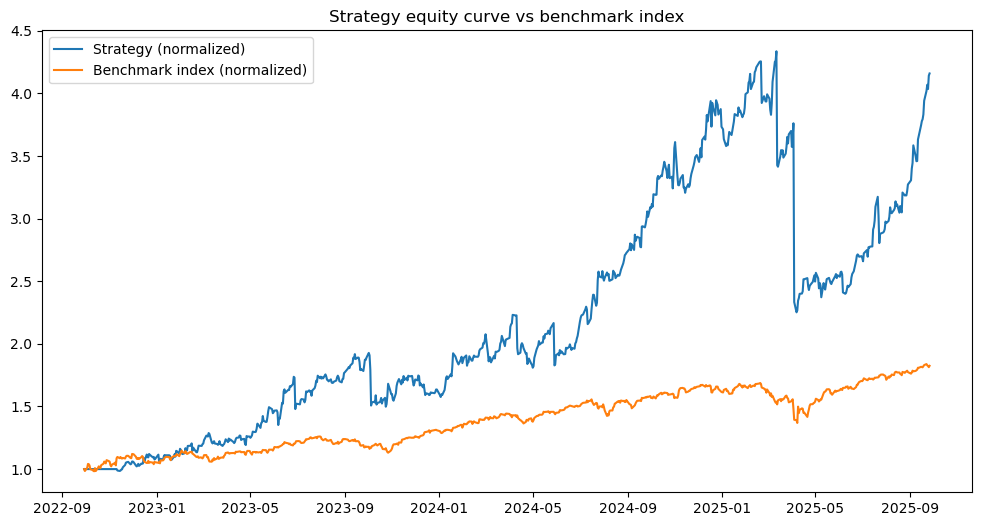

Sample trades (trades_oos):


,date,ticker,action,price,size_cash,direction
0,2022-11-10,HD,ENTER,288.930389,1.023248e+06,1
1,2022-11-10,JPM,ENTER,126.065002,1.265146e+06,1
2,2022-11-10,MRK,ENTER,93.164871,2.025561e+06,1
3,2022-11-10,PEP,ENTER,165.151718,1.295275e+06,1
4,2022-11-10,UNH,ENTER,517.018066,1.338134e+06,1
...,...,...,...,...,...,...
2240,2025-09-22,UNH,EXIT_SHORT_SIGNAL_REVERSAL,341.299988,5.599720e+06,-1
2241,2025-09-23,BRK-B,EXIT_SHORT_STOP,494.100006,1.010888e+07,-1
2242,2025-09-23,XOM,EXIT_SHORT_STOP,113.949997,3.096909e+07,-1
2243,2025-09-24,BRK-B,ENTER,497.089996,3.255492e+07,-1


equity_oos:


Date
2022-09-29    1.000000e+07
2022-09-30    1.000000e+07
2022-10-03    1.000000e+07
2022-10-04    1.000000e+07
2022-10-05    1.000000e+07
                  ...     
2025-09-22    4.020274e+07
2025-09-23    4.069365e+07
2025-09-24    4.035449e+07
2025-09-25    4.141985e+07
2025-09-26    4.159818e+07
Length: 751, dtype: float64

In [25]:
print('Running out-of-sample backtest...')
trades_oos, equity_oos = run_backtest(out_prices, indx.loc[out_prices.index], momentum_z.loc[out_prices.index], 
                                      risk_signal.loc[out_prices.index] if risk_signal is not None else None, CONTROL_PANEL)
# indx_series = indx.squeeze() # converts indx from a df to a series. compute_performance_metrics() needs to be fed a series not a dataframe
metrics_oos, daily_rets = compute_performance_metrics(equity_oos, benchmark_prices=indx)

percentage_keys = {
    'annual_return',
    'annual_volatility',
    'max_drawdown',
    'win_ratio',
    'total_return'
}

for k, v in metrics_oos.items():
    try:
        if k in percentage_keys:
            print(f'{k}: {v * 100:.2f}%')
        else:
            print(f'{k}: {v:.2f}')
    except (TypeError, ValueError):
        print(f'{k}: {v}')


# plot equity
plt.figure(figsize=(12,6))
eq_norm = equity_oos / equity_oos.iloc[0]
bench_norm = indx.loc[eq_norm.index] / indx.loc[eq_norm.index].iloc[0]
plt.plot(eq_norm.index, eq_norm.values, label='Strategy (normalized)')
plt.plot(bench_norm.index, bench_norm.values, label='Benchmark index (normalized)')
plt.legend()
plt.title('Strategy equity curve vs benchmark index')
plt.show()

print('Sample trades (trades_oos):')
display(trades_oos)
trades_oos.to_csv("trades_oos.csv", index=True)

print('equity_oos:')
display(equity_oos)
equity_oos.to_csv("equity_oos.csv", index=True)